In [3]:
library(gridExtra)
library(matrixStats)
library(dplyr)
library(rlang)
library(reshape2)
library(clusterCrit)
library(grid)
library(ggrepel)
library(RColorBrewer)

library(dplyr)
library(IRdisplay)
library(scales)
library(survival)
library(corrplot)
library(Hmisc)
library(ggplot2)
library(survminer)
library(muhaz)
library(dplyr)
library(stringr)
options(warn=-1)
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(broom)

library(logistf)
library(ggfortify)
library(rpart)
library(rpart.plot)
library(arules)
source("../../../../src/ggstyles.R")
source("../../../../src/tools.R")
source("../../../script_figures/tools.R")



In [4]:
tmp <-read.table('../handovercompiled.Yanis.080919.csv',sep=",",header=T)
rownames(tmp) <- tmp$data_pd
cols_to_keep <- colnames(tmp)
master <- read.table('../../../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
rownames(master) <- master$data_pd
df <- read.table('../../../clustering/clustering_Final_1/df_final_full_component.tsv')
df_merge_post_course <- merge(df,master[,c(cols_to_keep)],by=0)
rownames(df_merge_post_course) <- df_merge_post_course$Row.names
df_merge_post_course <- df_merge_post_course[-1]
df_merge_post_course$AMLID <- as.character(df_merge_post_course$AMLID)
df_merge_post_course$MRD1 <- as.character(df_merge_post_course$MRD1)
df_merge_post_course$MRD2 <- as.character(df_merge_post_course$MRD2)
df_merge_post_course <- df_merge_post_course[grep("17-", df_merge_post_course$AMLID),]   ### keep only AML 17

df_merge_post_course$CR_MRD_neg_pc1 <- ifelse(df_merge_post_course$MRD1=="CR,MRD-",1,0)
df_merge_post_course[is.na(df_merge_post_course$CR_MRD_neg_pc1),"CR_MRD_neg_pc1"] <- 0
df_merge_post_course$CR_MRD_pos_pc1 <- ifelse(df_merge_post_course$MRD1=="CR,MRD+",1,0)
df_merge_post_course[is.na(df_merge_post_course$CR_MRD_pos_pc1),"CR_MRD_pos_pc1"] <- 0
df_merge_post_course$all_others_pc1 <- ifelse((df_merge_post_course$CR_MRD_neg_pc1==0 & df_merge_post_course$CR_MRD_pos_pc1==0),1,0)

df_merge_post_course$CR_MRD_neg_pc2 <- ifelse(df_merge_post_course$MRD2=="CR,MRD-",1,0)
df_merge_post_course[is.na(df_merge_post_course$CR_MRD_neg_pc2),"CR_MRD_neg_pc2"] <- 0
df_merge_post_course$CR_MRD_pos_pc2 <- ifelse(df_merge_post_course$MRD2=="CR,MRD+",1,0)
df_merge_post_course[is.na(df_merge_post_course$CR_MRD_pos_pc2),"CR_MRD_pos_pc2"] <- 0
df_merge_post_course$all_others_pc2 <- ifelse((df_merge_post_course$CR_MRD_neg_pc2==0 & df_merge_post_course$CR_MRD_pos_pc2==0),1,0)

df_merge_post_course <- df_merge_post_course[!is.na(df_merge_post_course$OS_CR),]
df_merge_post_course <- df_merge_post_course[!is.na(df_merge_post_course$MRD1),]   ## we do it based on MRD1 to have exactly same patients in the comparison post course 1 vs post course 2 study!!!
df_merge_post_course <- df_merge_post_course[df_merge_post_course$os >0 & df_merge_post_course$OS_CR >0 & df_merge_post_course$RFSyears>0,]




eln <- colnames(df_merge_post_course[,c(2,3,4)])

# remove comp always0 in df_merge otherwise 
age <- c(167)

genes<- colnames(df_merge_post_course[,c(5:88)])

cytos <- colnames(df_merge_post_course[,c(89:158)])       
              
clin <- colnames(df_merge_post_course[,c(159:165)])
demo <- colnames(df_merge_post_course[,c(166:167)])
mrd <- colnames(df_merge_post_course[,c(227:232)])

all_gen <- c(5:88)
vect <- apply(X=df_merge_post_course[,all_gen],2,FUN=function(x) 100*length(which(x==1))/dim(df_merge_post_course)[1])
gen <- colnames(df_merge_post_course[,match(names(vect[vect>=2]),names(df_merge_post_course))])

all_cyto <- c(89:158)
vect <- apply(X=df_merge_post_course[,all_cyto],2,FUN=function(x) 100*length(which(x==1))/dim(df_merge_post_course)[1])
cyto <- colnames(df_merge_post_course[,match(names(vect[vect>=2]),names(df_merge_post_course))])
              
comp <- colnames(df_merge_post_course[,c(170:186)])
comp <- comp[colSums(df_merge_post_course[,comp])>0]

# I) MRD Negative Predictors

# 1) COMPONENTS

# A) Association Rule Learning

In [87]:
tmp <- df_merge[,c(comp,"CR_MRD_neg")]
tmp$no_CR_MRD_neg <- ifelse(tmp$CR_MRD_neg==0,1,0)
tmp$CR_MRD_neg <- NULL
tmp <- cbind.data.frame(tmp,Description = apply(tmp, 1, function(x)paste(colnames(tmp)[x[1:length(x)] == 1], collapse = ", ")))
tmp <- tmp[,ncol(tmp)]
tmp <- data.frame(itemList=tmp)
write.csv(tmp,"ItemList.csv", quote = FALSE, row.names = TRUE)

txn = read.transactions(file="ItemList.csv", rm.duplicates= TRUE, format="basket",sep=",",cols=1)
txn@itemInfo$labels <- gsub("\"","",txn@itemInfo$labels)
rules <- apriori(txn,parameter = list(sup = 0.01, conf = 0.5,target="rules"))
                                                
ruledf = data.frame(
       lhs = labels(lhs(rules)),
       rhs = labels(rhs(rules)), 
       rules@quality)
ruledf <- ruledf[ ruledf$rhs=="{no_CR_MRD_neg}" & ruledf$lift >1 & ruledf$confidence >=0.8,]
colnames(ruledf)[colnames(ruledf) %in% c("lhs","rhs")] <- c("Rules","Target")


Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 7 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[18 item(s), 744 transaction(s)] done [0.00s].
sorting and recoding items ... [14 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [53 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [56]:
head(ruledf[order(ruledf$lift,decreasing=T),],10)

,Rules,Target,support,confidence,lift,count
25,"{full_component_additions,full_component_TP53_complex}",{no_CR_MRD_neg},0.02553763,0.9500000,1.235664,19
45,"{full_component_additions,full_component_TP53_complex,overlap}",{no_CR_MRD_neg},0.02553763,0.9500000,1.235664,19
14,{full_component_TP53_complex},{no_CR_MRD_neg},0.07392473,0.9166667,1.192308,55
36,"{full_component_TP53_complex,overlap}",{no_CR_MRD_neg},0.03763441,0.8750000,1.138112,28
12,{full_component_DNMT3A_IDH1_2},{no_CR_MRD_neg},0.05107527,0.8636364,1.123331,38
3,{full_component_WT1},{no_CR_MRD_neg},0.02956989,0.8461538,1.100592,22
33,"{full_component_chr_splicing_multiple,full_component_DNMT3A_IDH1_2}",{no_CR_MRD_neg},0.02150538,0.8421053,1.095326,16
51,"{full_component_chr_splicing_multiple,full_component_DNMT3A_IDH1_2,overlap}",{no_CR_MRD_neg},0.02150538,0.8421053,1.095326,16
10,{full_component_additions},{no_CR_MRD_neg},0.04704301,0.8333333,1.083916,35
29,"{full_component_additions,overlap}",{no_CR_MRD_neg},0.03897849,0.8285714,1.077722,29


In [6]:
tmp <- df_merge[,c(comp,"CR_MRD_neg")]
tmp <- cbind.data.frame(tmp,Description = apply(tmp, 1, function(x)paste(colnames(tmp)[x[1:length(x)] == 1], collapse = ", ")))
tmp <- tmp[,ncol(tmp)]
tmp <- data.frame(itemList=tmp)
write.csv(tmp,"ItemList.csv", quote = FALSE, row.names = TRUE)

txn = read.transactions(file="ItemList.csv", rm.duplicates= TRUE, format="basket",sep=",",cols=1)
txn@itemInfo$labels <- gsub("\"","",txn@itemInfo$labels)
rules <- apriori(txn,parameter = list(sup = 0.01, conf = 0.3,target="rules"))
                                                
ruledf = data.frame(
       lhs = labels(lhs(rules)),
       rhs = labels(rhs(rules)), 
       rules@quality)
ruledf <- ruledf[ ruledf$rhs=="{CR_MRD_neg}",]
colnames(ruledf)[colnames(ruledf) %in% c("lhs","rhs")] <- c("Rules","Target")

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.3    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 7 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[18 item(s), 744 transaction(s)] done [0.00s].
sorting and recoding items ... [14 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [32 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


# B) Univariate and Multivariate Regression

In [28]:
table(df_merge$del_9)


  0   1 
713  30 

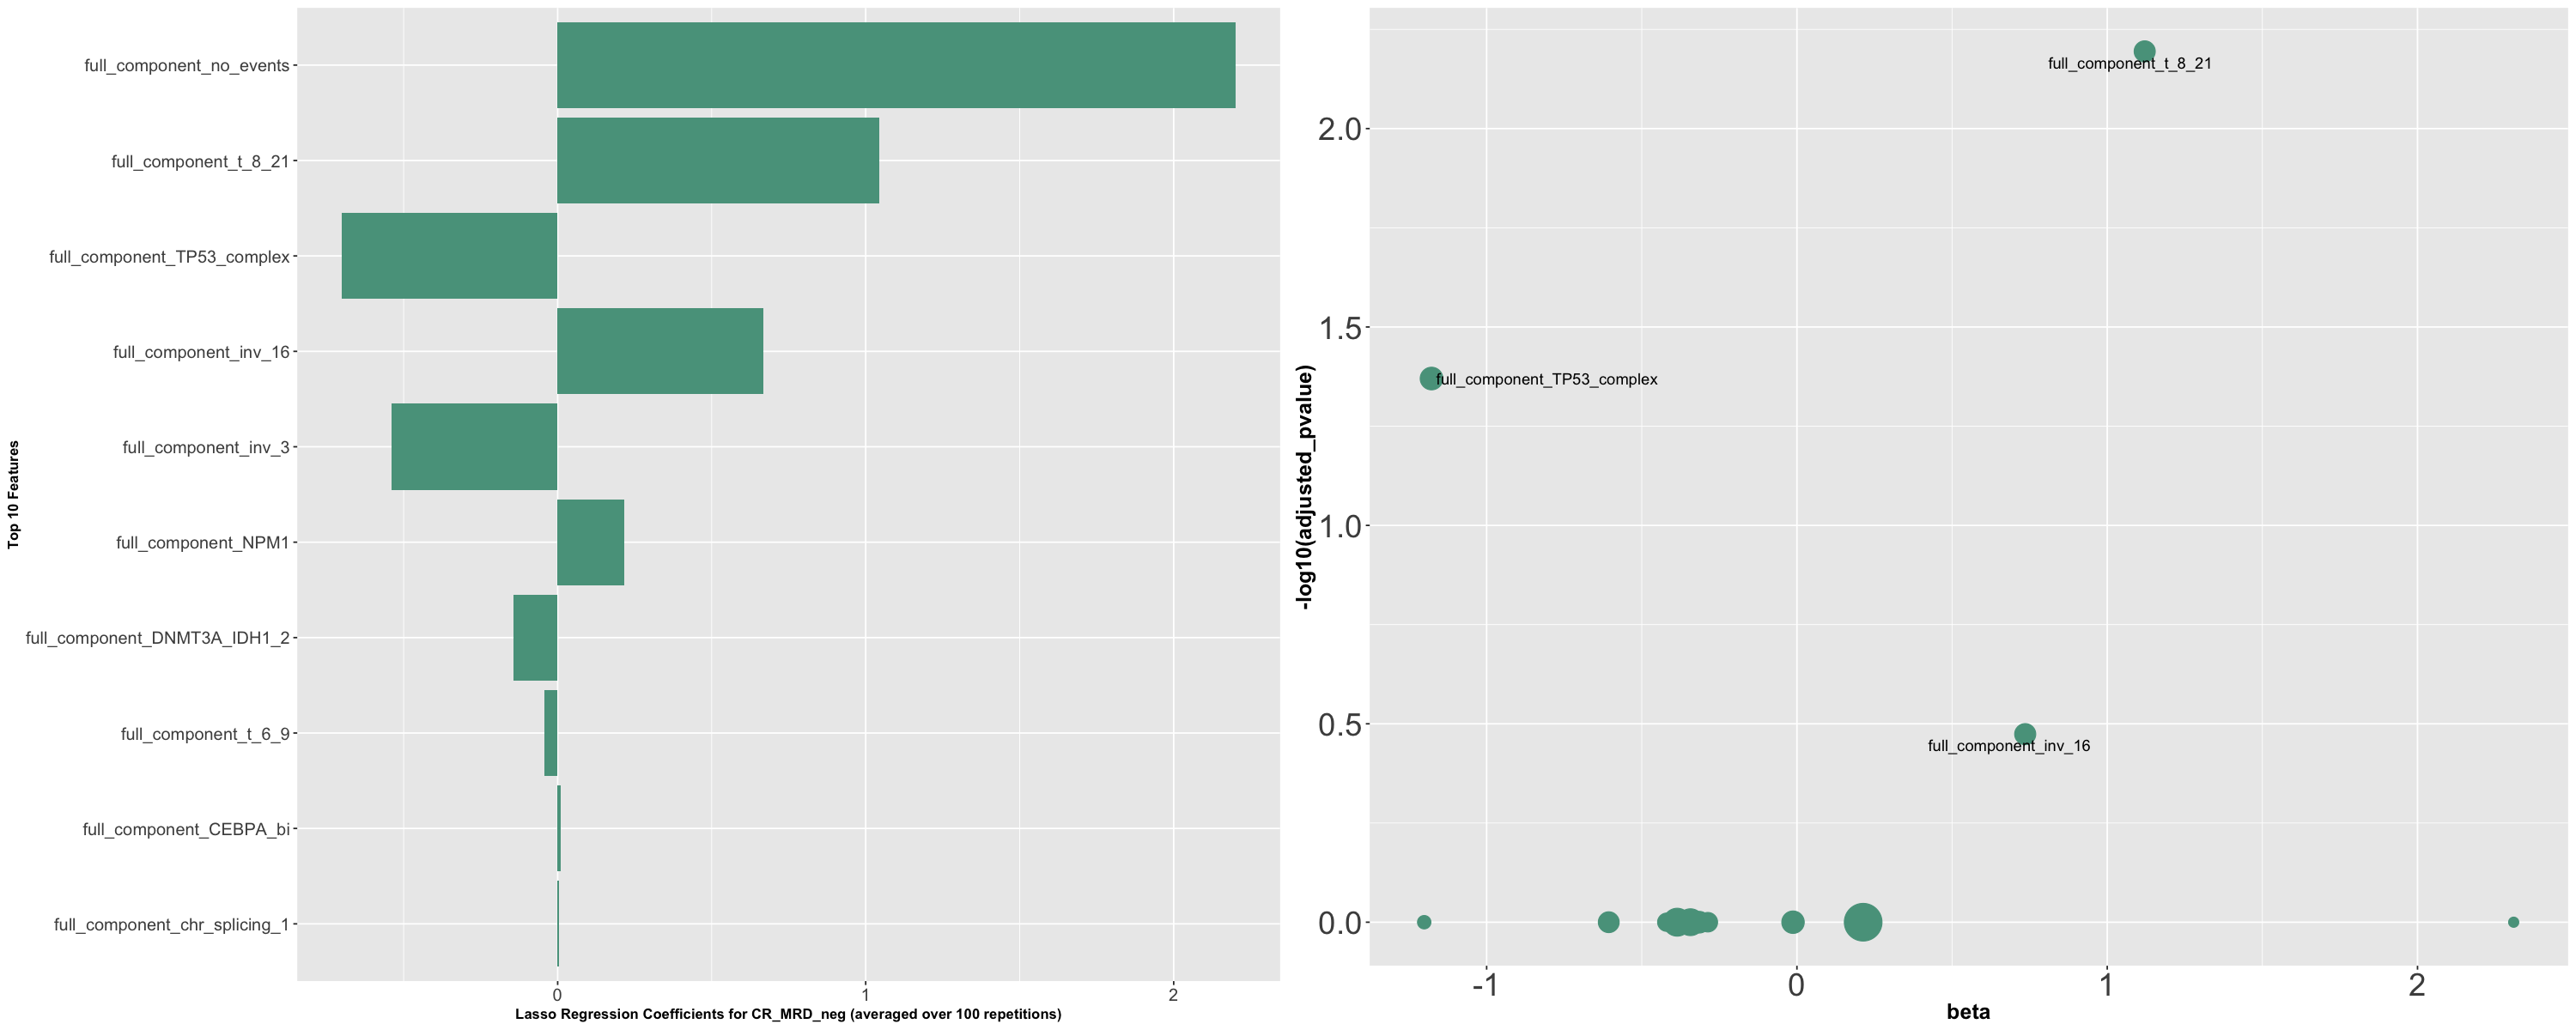

In [25]:
set_notebook_plot_size(25,10)
p <- multivariate_regression(df_merge,"CR_MRD_neg",features=c(comp),fam="binomial",num_iterations = 100,size_title=10)
q <- univariate_volcano(df_merge,"CR_MRD_neg",features=c(comp),type="binary",quantile=c(0,1),p_value_threshold=0.05,size_title=15,legend.position="none")
grid.arrange(p,q,nrow=1)

In [26]:
png("mrd_negative_components.png",width=7000,height=3550,res=420)
grid.arrange(p,q,nrow=1)
dev.off()

pdf 
  2

# 2) Genes and Cytos

# A) Association rules learning

In [43]:
tmp <- df_merge[,c(gen,cyto,"CR_MRD_neg")]
tmp$no_CR_MRD_neg <- ifelse(tmp$CR_MRD_neg==0,1,0)
tmp$CR_MRD_neg <- NULL
tmp <- cbind.data.frame(tmp,Description = apply(tmp, 1, function(x)paste(colnames(tmp)[x[1:length(x)] == 1], collapse = ", ")))
tmp <- tmp[,ncol(tmp)]
tmp <- data.frame(itemList=tmp)
write.csv(tmp,"ItemList.csv", quote = FALSE, row.names = TRUE)

txn = read.transactions(file="ItemList.csv", rm.duplicates= TRUE, format="basket",sep=",",cols=1)
txn@itemInfo$labels <- gsub("\"","",txn@itemInfo$labels)
rules <- apriori(txn,parameter = list(sup = 0.01, conf = 0.5,target="rules"))
                                                
ruledf = data.frame(
       lhs = labels(lhs(rules)),
       rhs = labels(rhs(rules)), 
       rules@quality)
ruledf <- ruledf[ ruledf$rhs=="{no_CR_MRD_neg}" & ruledf$lift >1.3 & ruledf$confidence >=0.8,]
colnames(ruledf)[colnames(ruledf) %in% c("lhs","rhs")] <- c("Rules","Target")


Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 7 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[50 item(s), 744 transaction(s)] done [0.00s].
sorting and recoding items ... [49 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 5 done [0.00s].
writing ... [441 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [50]:
table(df_merge$NRAS_p.G12_13,df_merge$CR_MRD_neg)

   
      0   1
  0 501 148
  1  71  23

In [49]:
ruledf[order(ruledf$support,decreasing=T),]

,Rules,Target,support,confidence,lift,count
64,{TP53},{no_CR_MRD_neg},0.05645161,1,1.300699,42
223,"{complex,TP53}",{no_CR_MRD_neg},0.04704301,1,1.300699,35
60,{del_5},{no_CR_MRD_neg},0.04569892,1,1.300699,34
208,"{del_5,TP53}",{no_CR_MRD_neg},0.03629032,1,1.300699,27
212,"{complex,del_5}",{no_CR_MRD_neg},0.03494624,1,1.300699,26
379,"{complex,del_5,TP53}",{no_CR_MRD_neg},0.03494624,1,1.300699,26
283,"{NRAS_p.G12_13,TET2}",{no_CR_MRD_neg},0.02284946,1,1.300699,17
28,{del_17},{no_CR_MRD_neg},0.02150538,1,1.300699,16
122,"{del_17,TP53}",{no_CR_MRD_neg},0.02150538,1,1.300699,16
217,"{del_7,TP53}",{no_CR_MRD_neg},0.02150538,1,1.300699,16


In [10]:
tmp <- df_merge[,c(gen,cyto,"CR_MRD_neg")]
tmp <- cbind.data.frame(tmp,Description = apply(tmp, 1, function(x)paste(colnames(tmp)[x[1:length(x)] == 1], collapse = ", ")))
tmp <- tmp[,ncol(tmp)]
tmp <- data.frame(itemList=tmp)
write.csv(tmp,"ItemList.csv", quote = FALSE, row.names = TRUE)

txn = read.transactions(file="ItemList.csv", rm.duplicates= TRUE, format="basket",sep=",",cols=1)
txn@itemInfo$labels <- gsub("\"","",txn@itemInfo$labels)
rules <- apriori(txn,parameter = list(sup = 0.01, conf = 0.5,target="rules"))
                                                
ruledf = data.frame(
       lhs = labels(lhs(rules)),
       rhs = labels(rhs(rules)), 
       rules@quality)
ruledf <- ruledf[ ruledf$rhs=="{CR_MRD_neg}",]
colnames(ruledf)[colnames(ruledf) %in% c("lhs","rhs")] <- c("Rules","Target")


Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 7 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[50 item(s), 744 transaction(s)] done [0.00s].
sorting and recoding items ... [49 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [150 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [11]:
ruledf[order(ruledf$count,decreasing=T),]

,Rules,Target,support,confidence,lift,count
14,{minusy},{CR_MRD_neg},0.01478495,0.5000000,2.175439,11
52,"{minusy,t_8_21}",{CR_MRD_neg},0.01478495,0.6470588,2.815273,11
59,"{del_9,t_8_21}",{CR_MRD_neg},0.01075269,0.6666667,2.900585,8


# B) Univariate and Multivariate Regression

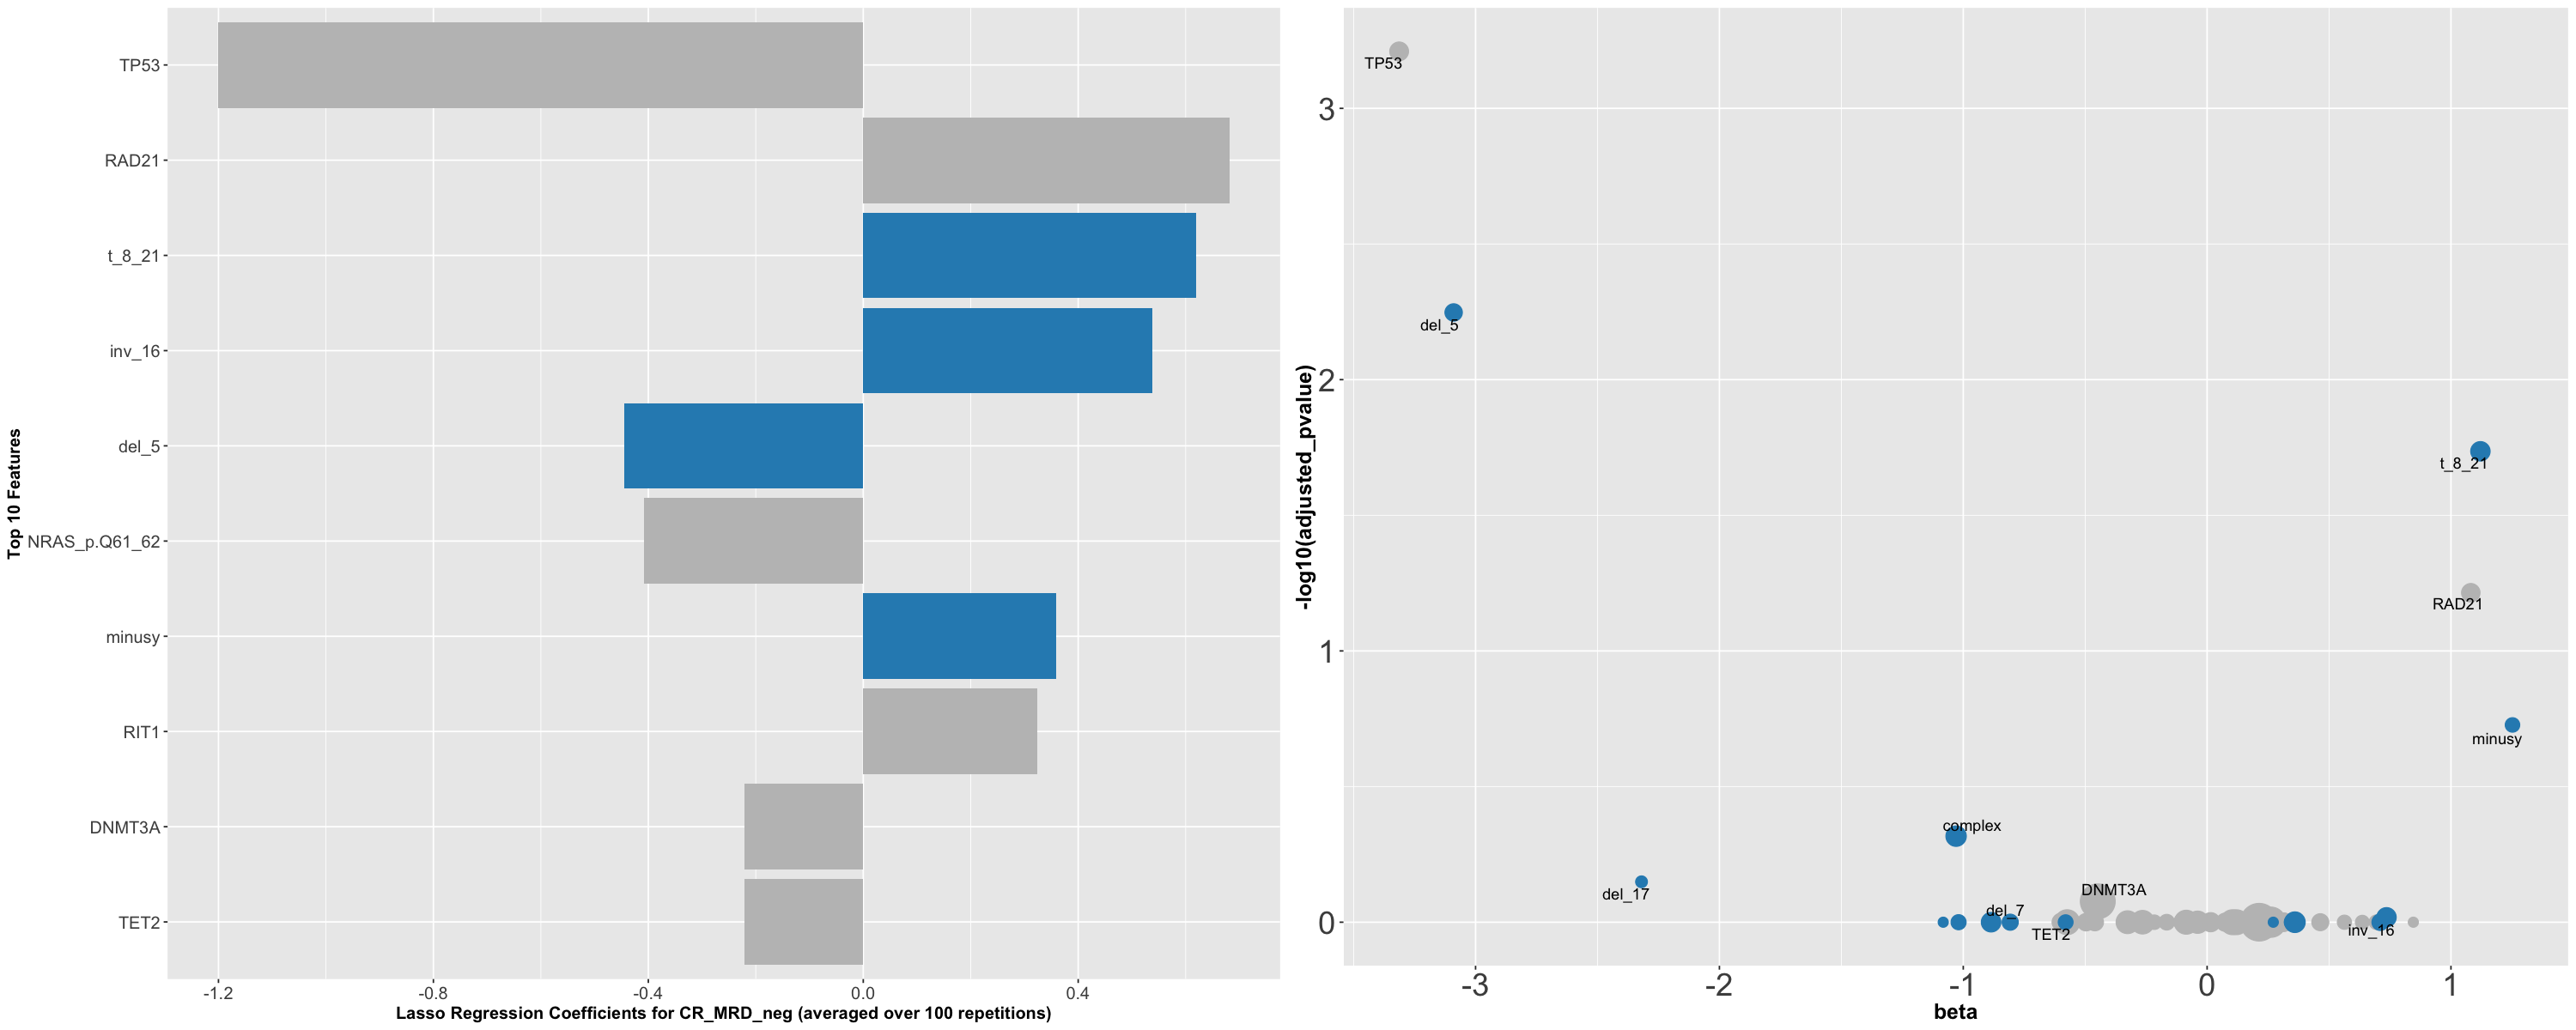

In [52]:
set_notebook_plot_size(25,10)
p <- multivariate_regression(df_merge,"CR_MRD_neg",features=c(gen,cyto),fam="binomial",num_iterations = 100,size_title=12,top_n=10)
q <- univariate_volcano(df_merge,"CR_MRD_neg",features=c(gen,cyto),type="binary",quantile=c(0,1),p_value_threshold=0.05,size_title=15,legend.position="none")
grid.arrange(p,q,nrow=1) 

In [18]:
png("mrd_negative_genes.png",width=7000,height=3550,res=420)
grid.arrange(p,q,nrow=1)
dev.off()

pdf 
  2

In [42]:
    nrow(df_merge[df_merge$TP53==1 & df_merge$all_others==1,])

[1] 27

# 3) Molecular, clinical and demographic

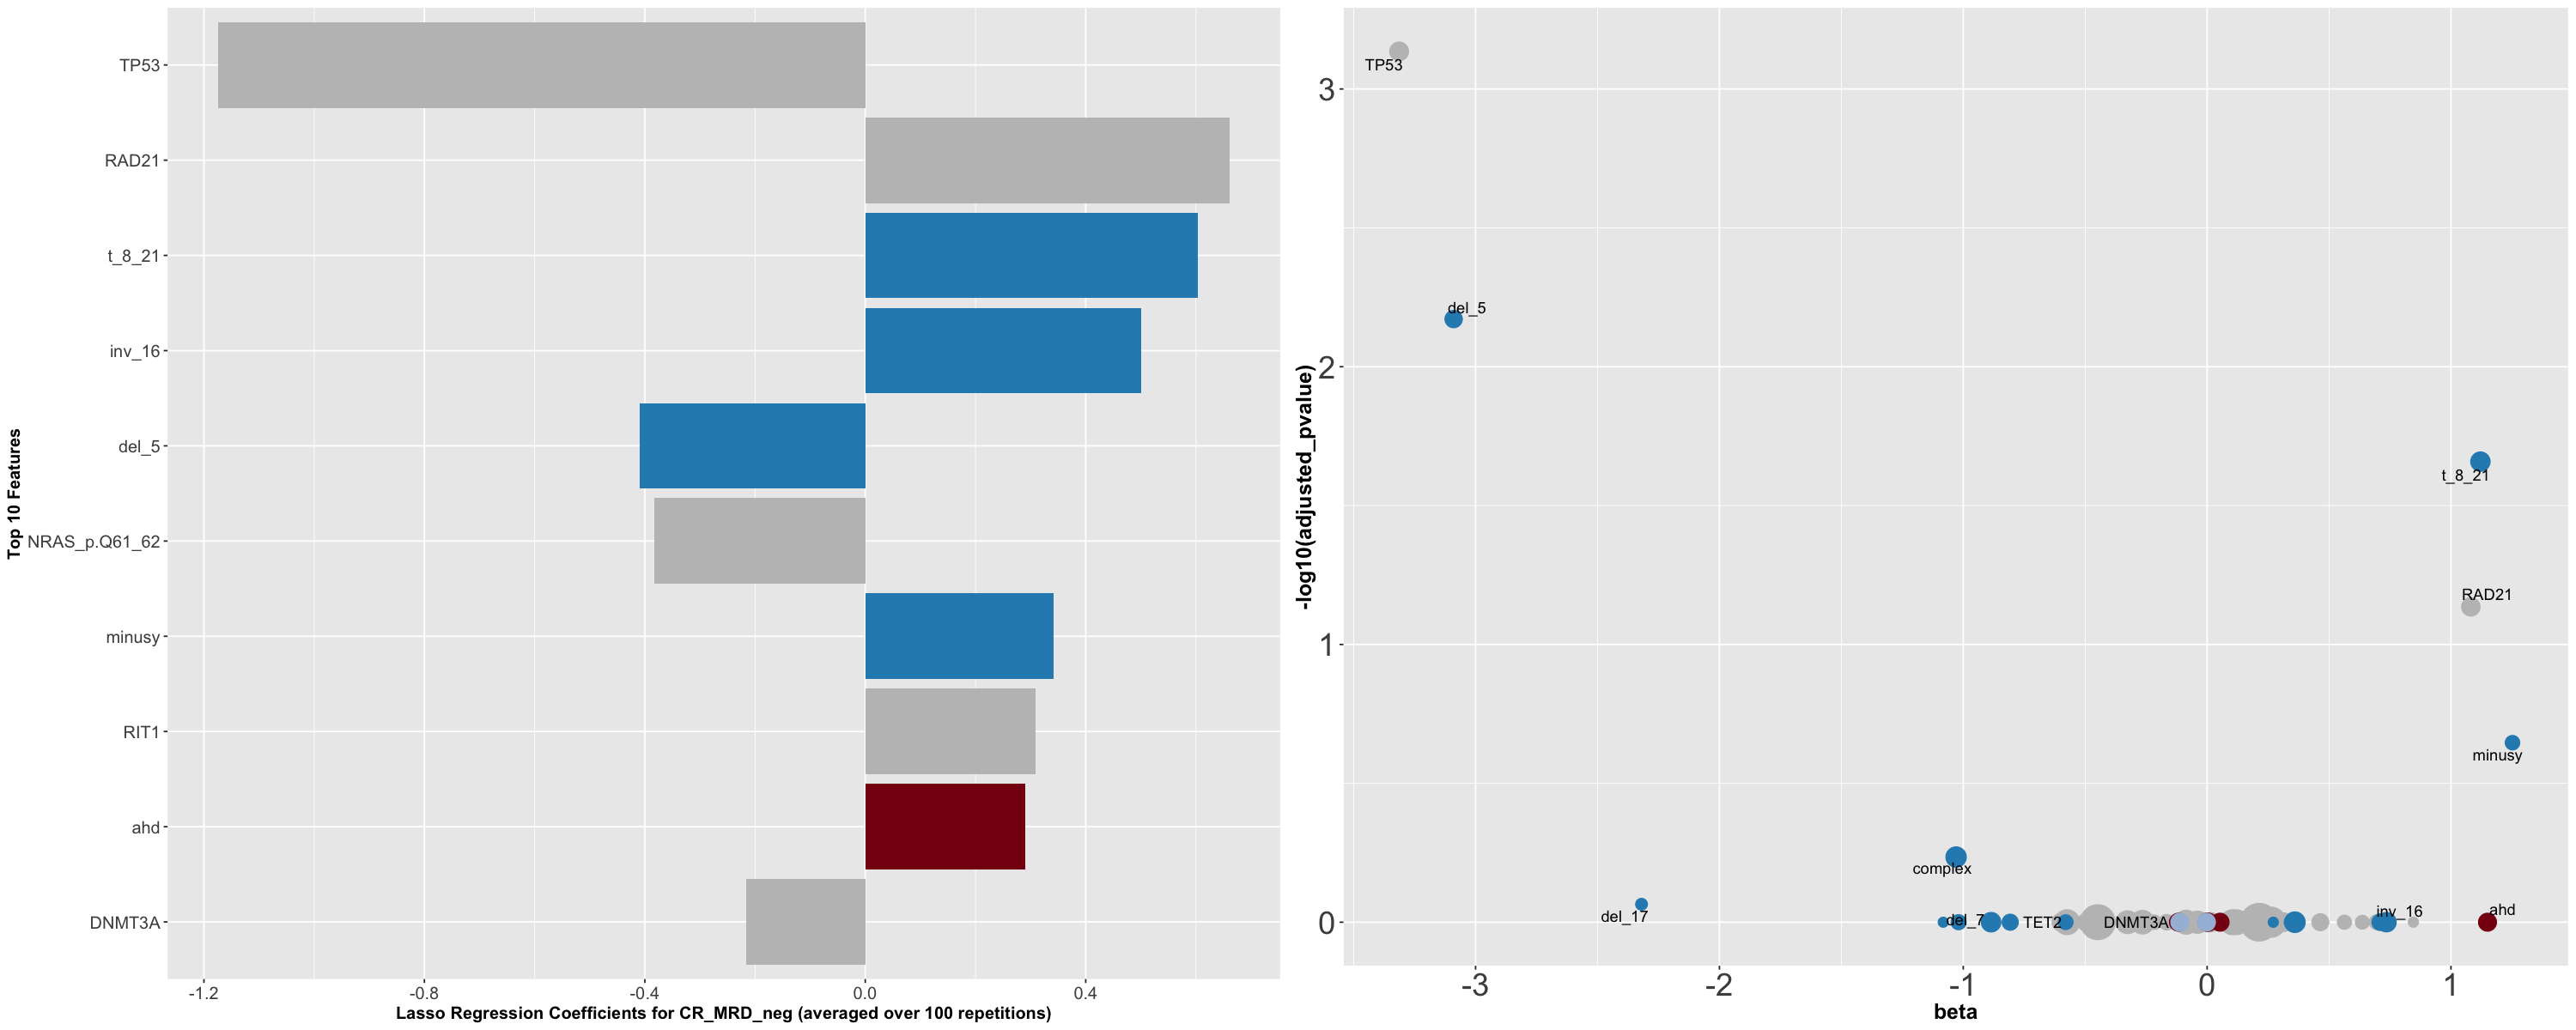

In [29]:
set_notebook_plot_size(25,10)
p <- multivariate_regression(df_merge,"CR_MRD_neg",features=c(gen,cyto,clin,demo),fam="binomial",num_iterations = 100,size_title=12)
q <- univariate_volcano(df_merge,"CR_MRD_neg",features=c(gen,cyto,clin,demo),type="binary",quantile=c(0,1),p_value_threshold=0.05,size_title=15,legend.position="none")
grid.arrange(p,q,nrow=1)

In [30]:
png("mrd_negative_all.png",width=7000,height=3550,res=420)
grid.arrange(p,q,nrow=1)
dev.off()

pdf 
  2

# II) MRD Positive Predictors

# 1) Components

# A) Association rules learning

In [ ]:
tmp <- df_merge[,c(comp,"CR_MRD_pos")]
tmp <- cbind.data.frame(tmp,Description = apply(tmp, 1, function(x)paste(colnames(tmp)[x[1:length(x)] == 1], collapse = ", ")))
tmp <- tmp[,ncol(tmp)]
tmp <- data.frame(itemList=tmp)
write.csv(tmp,"ItemList.csv", quote = FALSE, row.names = TRUE)

txn = read.transactions(file="ItemList.csv", rm.duplicates= TRUE, format="basket",sep=",",cols=1)
txn@itemInfo$labels <- gsub("\"","",txn@itemInfo$labels)
rules <- apriori(txn,parameter = list(sup = 0.01, conf = 0.5,target="rules"))
                                                
ruledf = data.frame(
       lhs = labels(lhs(rules)),
       rhs = labels(rhs(rules)), 
       rules@quality)
ruledf <- ruledf[ ruledf$rhs=="{CR_MRD_pos}",]


In [26]:
ruledf[order(ruledf$count,decreasing=T),]

lhs,rhs,support,confidence,lift,count


# B) Univariate and Multivariate Regression

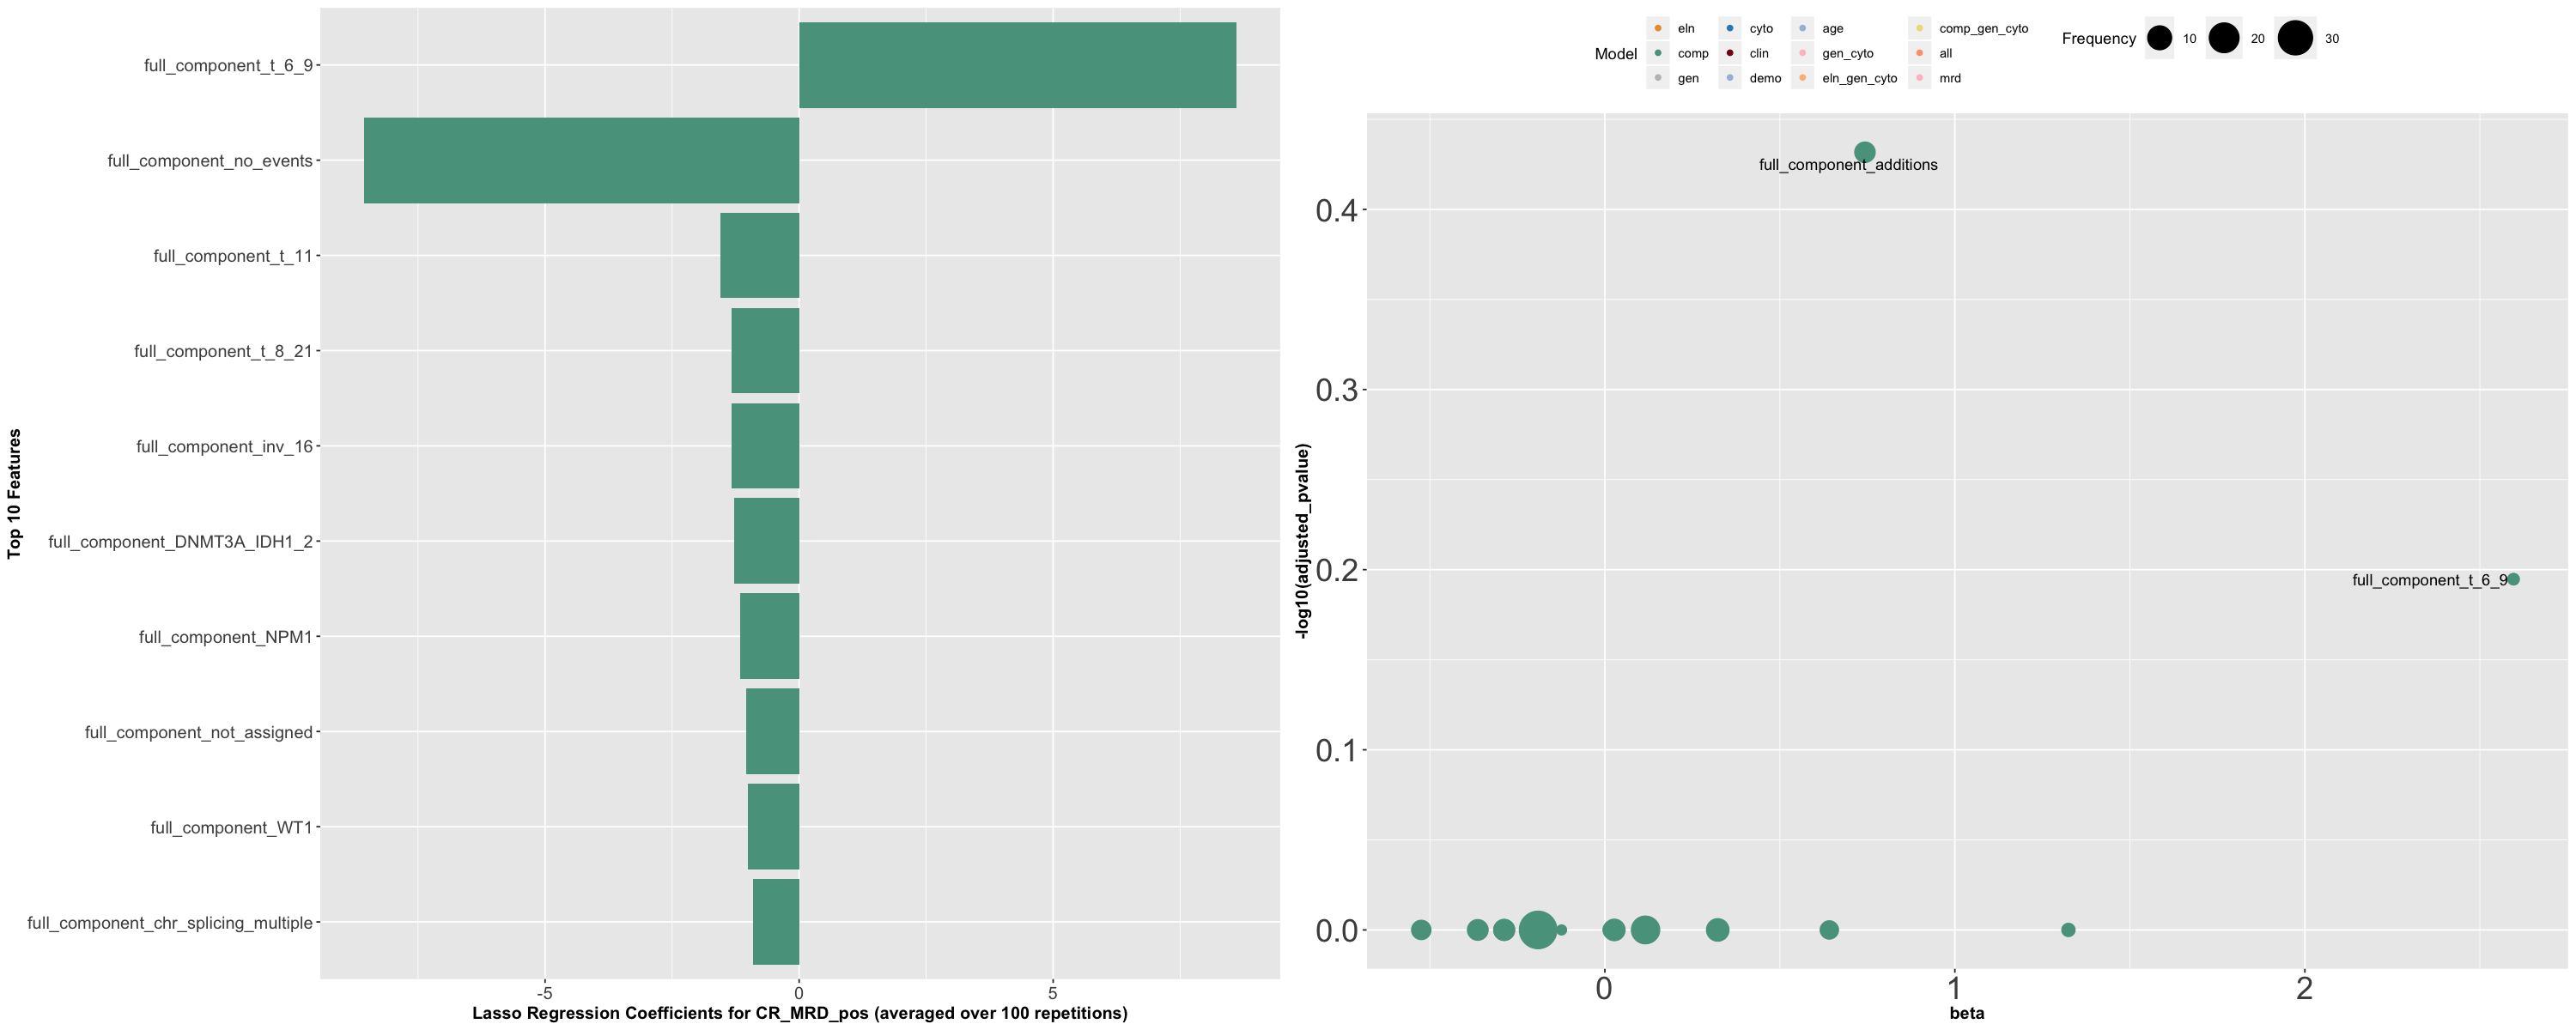

In [21]:
set_notebook_plot_size(25,10)
p <- multivariate_regression(df_merge,"CR_MRD_pos",features=c(comp),fam="binomial",num_iterations = 100,lambda=c(0,0.00001),size_title=12,size_axis = 12)
q <- univariate_volcano(df_merge,"CR_MRD_pos",features=c(comp),type="binary",quantile=c(0,1),p_value_threshold=0.05,size_title=12)
grid.arrange(p,q,nrow=1)

# 2) Genes and Cytos

# A) Association rules learning

In [ ]:
tmp <- df_merge[,c(gen,cyto,"CR_MRD_pos")]
tmp <- cbind.data.frame(tmp,Description = apply(tmp, 1, function(x)paste(colnames(tmp)[x[1:length(x)] == 1], collapse = ", ")))
tmp <- tmp[,ncol(tmp)]
tmp <- data.frame(itemList=tmp)
write.csv(tmp,"ItemList.csv", quote = FALSE, row.names = TRUE)

txn = read.transactions(file="ItemList.csv", rm.duplicates= TRUE, format="basket",sep=",",cols=1)
txn@itemInfo$labels <- gsub("\"","",txn@itemInfo$labels)
rules <- apriori(txn,parameter = list(sup = 0.008, conf = 0.5,target="rules"))
                                                
ruledf = data.frame(
       lhs = labels(lhs(rules)),
       rhs = labels(rhs(rules)), 
       rules@quality)
ruledf <- ruledf[ ruledf$rhs=="{CR_MRD_pos}",]


In [28]:
ruledf[order(ruledf$count,decreasing=T),]

,lhs,rhs,support,confidence,lift,count
175,"{NRAS_p.G12_13,PTPN11}",{CR_MRD_pos},0.010752688,0.5000000,1.832512,8
168,"{add_8,RUNX1}",{CR_MRD_pos},0.009408602,0.5833333,2.137931,7
67,"{del_17,del_5}",{CR_MRD_pos},0.008064516,0.5000000,1.832512,6
83,"{add_22,complex}",{CR_MRD_pos},0.008064516,0.5454545,1.999104,6
107,"{add_21,add_8}",{CR_MRD_pos},0.008064516,0.5454545,1.999104,6
169,"{add_8,DNMT3A}",{CR_MRD_pos},0.008064516,0.5454545,1.999104,6
228,"{del_17,del_5,TP53}",{CR_MRD_pos},0.008064516,0.5000000,1.832512,6
232,"{complex,del_17,del_5}",{CR_MRD_pos},0.008064516,0.5000000,1.832512,6
301,"{complex,del_17,del_5,TP53}",{CR_MRD_pos},0.008064516,0.5000000,1.832512,6


In [17]:
# Not enough confidence !

# B) Univariate and Multivariate Regression

In [ ]:
q

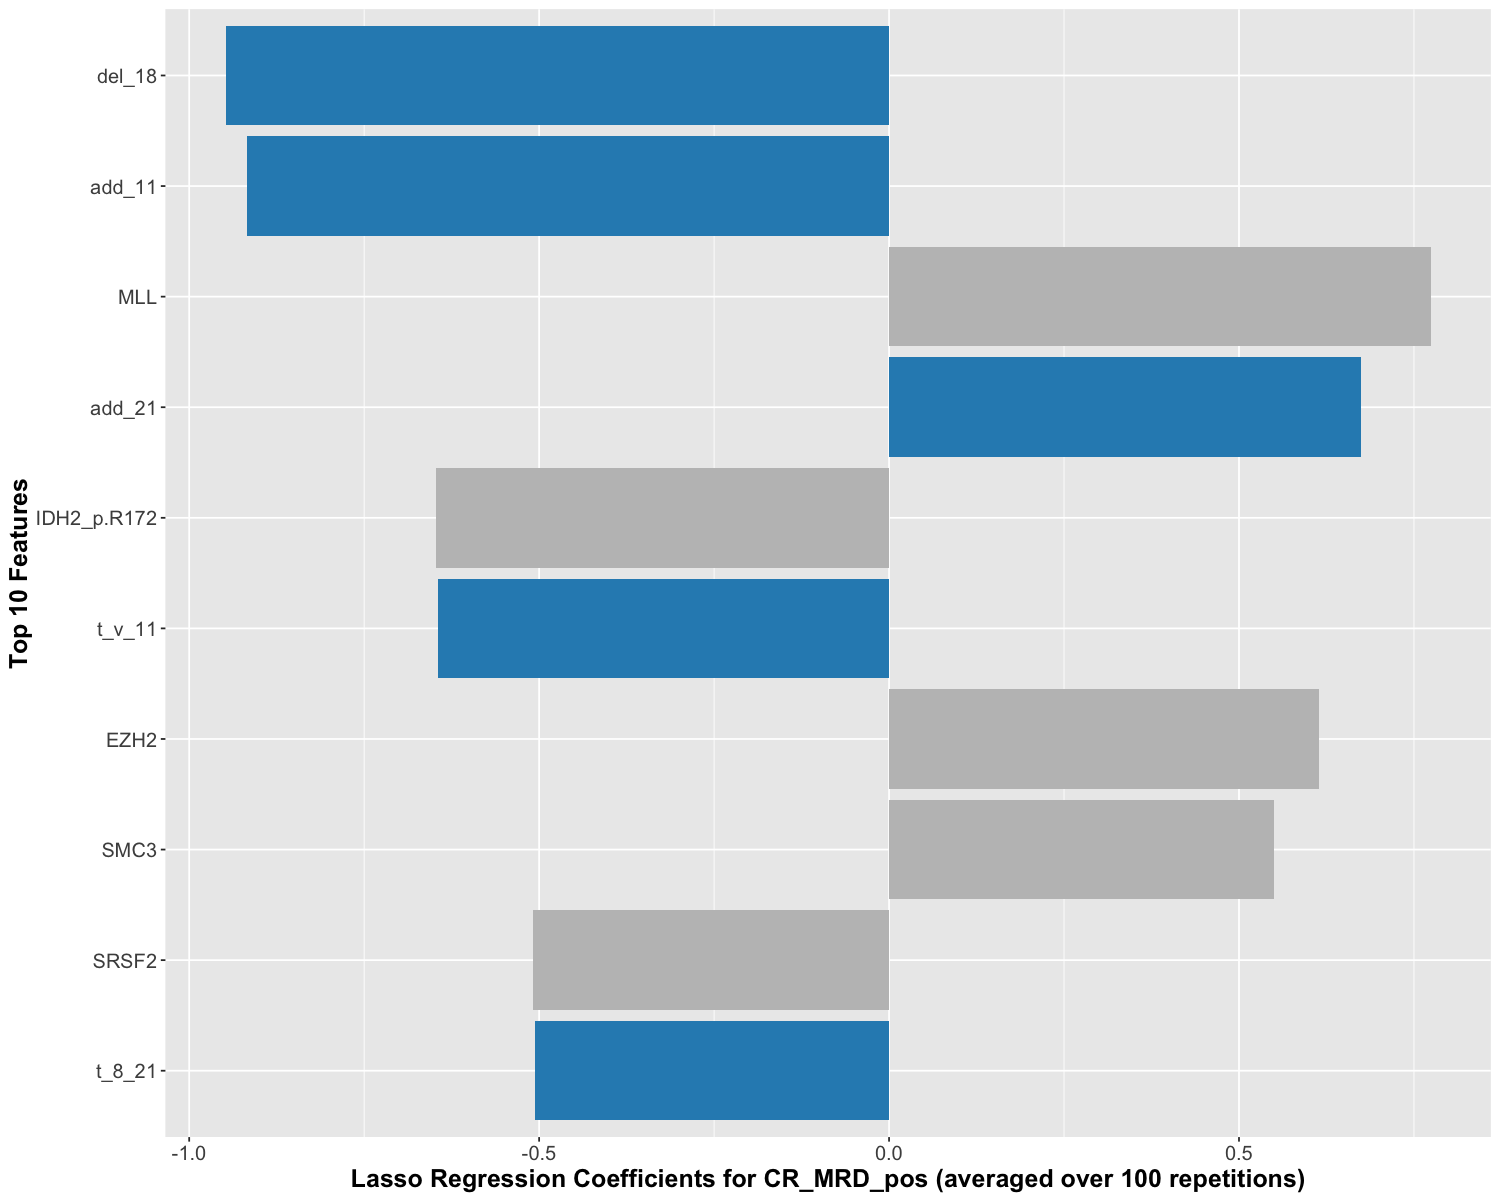

In [3]:
set_notebook_plot_size(12.5,10)
p <- multivariate_regression(df_merge,"CR_MRD_pos",features=c(gen,cyto),fam="binomial",num_iterations = 100,lambda=c(0,0.00001),size_title=15)
q <- univariate_volcano(df_merge,"CR_MRD_pos",features=c(gen,cyto),type="binary",quantile=c(0,1),p_value_threshold=0.05,size_title=15)
p

# III ) MRD Impact on End Points


In [15]:
colors_analysis <- c(eln="#EE9937",comp="#59A08B",gen="#BFBFBF",cyto="#2b8cbe",clin="#870C14",demo="#a6bddb",gen_cyto="pink",eln_gen_cyto="#fdbb84",comp_gen_cyto="lightgoldenrod",all="lightsalmon",mrd="pink")

# III.1) RFS

In [5]:
    ## Volcano Plot Univariate
    
df <- data.frame(hazard = double(),pvalue = double(),Frequency = double() )
data <- df_merge_post_course

for (col in c(gen,cyto,mrd,clin,demo)){
    surv_object <- Surv(time = data$RFSyears, event = data$RFSStatus)
    fit <- coxph(as.formula(paste("Surv(RFSyears,RFSStatus) ~ ",
                       col)), data = data)

    df[col,1:3] <- c(summary(fit)$coef[2],summary(fit)$sctest[["pvalue"]],100*sum(data[,col])/dim(data)[1])                 
     }
df[,"adjusted_pvalue"] <- p.adjust(df$pvalue)
df[,"-log10(adjusted_pvalue)"] <- -log(p.adjust(df$pvalue),10)
df[,"log2(hazard)"] <- log(df$hazard,2)
df["names"] <- rownames(df)
df$Model <- ifelse(df$names %in% gen,"gen",
                  ifelse(df$names %in% cyto,"cyto",
                        ifelse(df$names %in% clin, "clin",
                              ifelse(df$names %in% demo, "demo",
                                    ifelse(df$names %in% eln, "eln",
                                           ifelse(df$names %in% mrd, "mrd","comp"))))))
df$Frequency <- ifelse(df$names %in% clin, 5,
                              ifelse(df$names %in% demo, 5, df$Frequency))

df <- df[order(df$adjusted_pvalue),]
s <- ggplot(df, aes(log2(hazard), -log10(adjusted_pvalue))) + #volcanoplot with log2Foldchange versus pvalue
    geom_point(aes(size=Frequency,col=Model)) + geom_text_repel(data=df[(df["adjusted_pvalue"]<0.05) | (df["log2(hazard)"]< -18),], aes(label=names,fontface=2))+scale_size_continuous(range = c(3,12)) + 
     scale_color_manual(values=colors_analysis,limits=names(colors_analysis))+  ## respect color in feature importance
    theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=12),axis.title=element_text(size=14,face="bold"))  + theme(legend.position="none")


## Multivariate Plot
   # we can not run lasso on a model without any events (variance 0)
data <- df_merge_post_course
df_multi <- NULL
i <- 1
for (i in c(1:100)){
    res1 <- cv.glmnet(data.matrix(data[,c(gen,cyto,mrd,clin,demo)]), Surv(data$RFSyears,data$RFSStatus), family="cox",alpha=1,nfolds=10)
    df_multi <- cbind(df_multi,as.matrix(coef(res1,s="lambda.min")))
    i <- i+1
    }

l <- data.frame(coef = rowSums(df_multi)/100)
l$names <- rownames(l)
l$Model <- ifelse(l$names %in% gen,"gen",
              ifelse(l$names %in% cyto,"cyto",
                    ifelse(l$names %in% clin, "clin",
                          ifelse(l$names %in% demo, "demo",
                                ifelse(l$names %in% eln, "eln",
                                       ifelse(l$names %in% mrd, "mrd","comp"))))))
l$abs_coef <- abs(l$coef)

t <- ggplot(l[l$coef!=0,],aes(x=reorder(names,abs_coef),y=coef,fill=Model))+geom_bar(stat="identity")+coord_flip()+
theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=14),axis.title=element_text(size=14,face="bold"))+
scale_fill_manual(values=colors_analysis,limits=names(colors_analysis)) + theme(legend.position="none")+ xlab("")



In [6]:
df[rownames(df)=="CR_MRD_pos_pc2",]
l

,hazard,pvalue,Frequency,adjusted_pvalue,-log10(adjusted_pvalue),log2(hazard),names,Model
CR_MRD_pos_pc2,1.499876,0.001025016,15.20861,0.0522758,1.281699,0.584843,CR_MRD_pos_pc2,mrd


,coef,names,Model,abs_coef
ASXL1,0.024935776,ASXL1,gen,0.024935776
BCOR,0.216137753,BCOR,gen,0.216137753
CEBPA_bi,-0.018523562,CEBPA_bi,gen,0.018523562
CEBPA_mono,-0.040316227,CEBPA_mono,gen,0.040316227
DNMT3A,0.206748831,DNMT3A,gen,0.206748831
EZH2,0.000000000,EZH2,gen,0.000000000
ITD,0.220335584,ITD,gen,0.220335584
FLT3_TKD,0.000000000,FLT3_TKD,gen,0.000000000
FLT3_other,-0.117715716,FLT3_other,gen,0.117715716
GATA2,-0.013948730,GATA2,gen,0.013948730


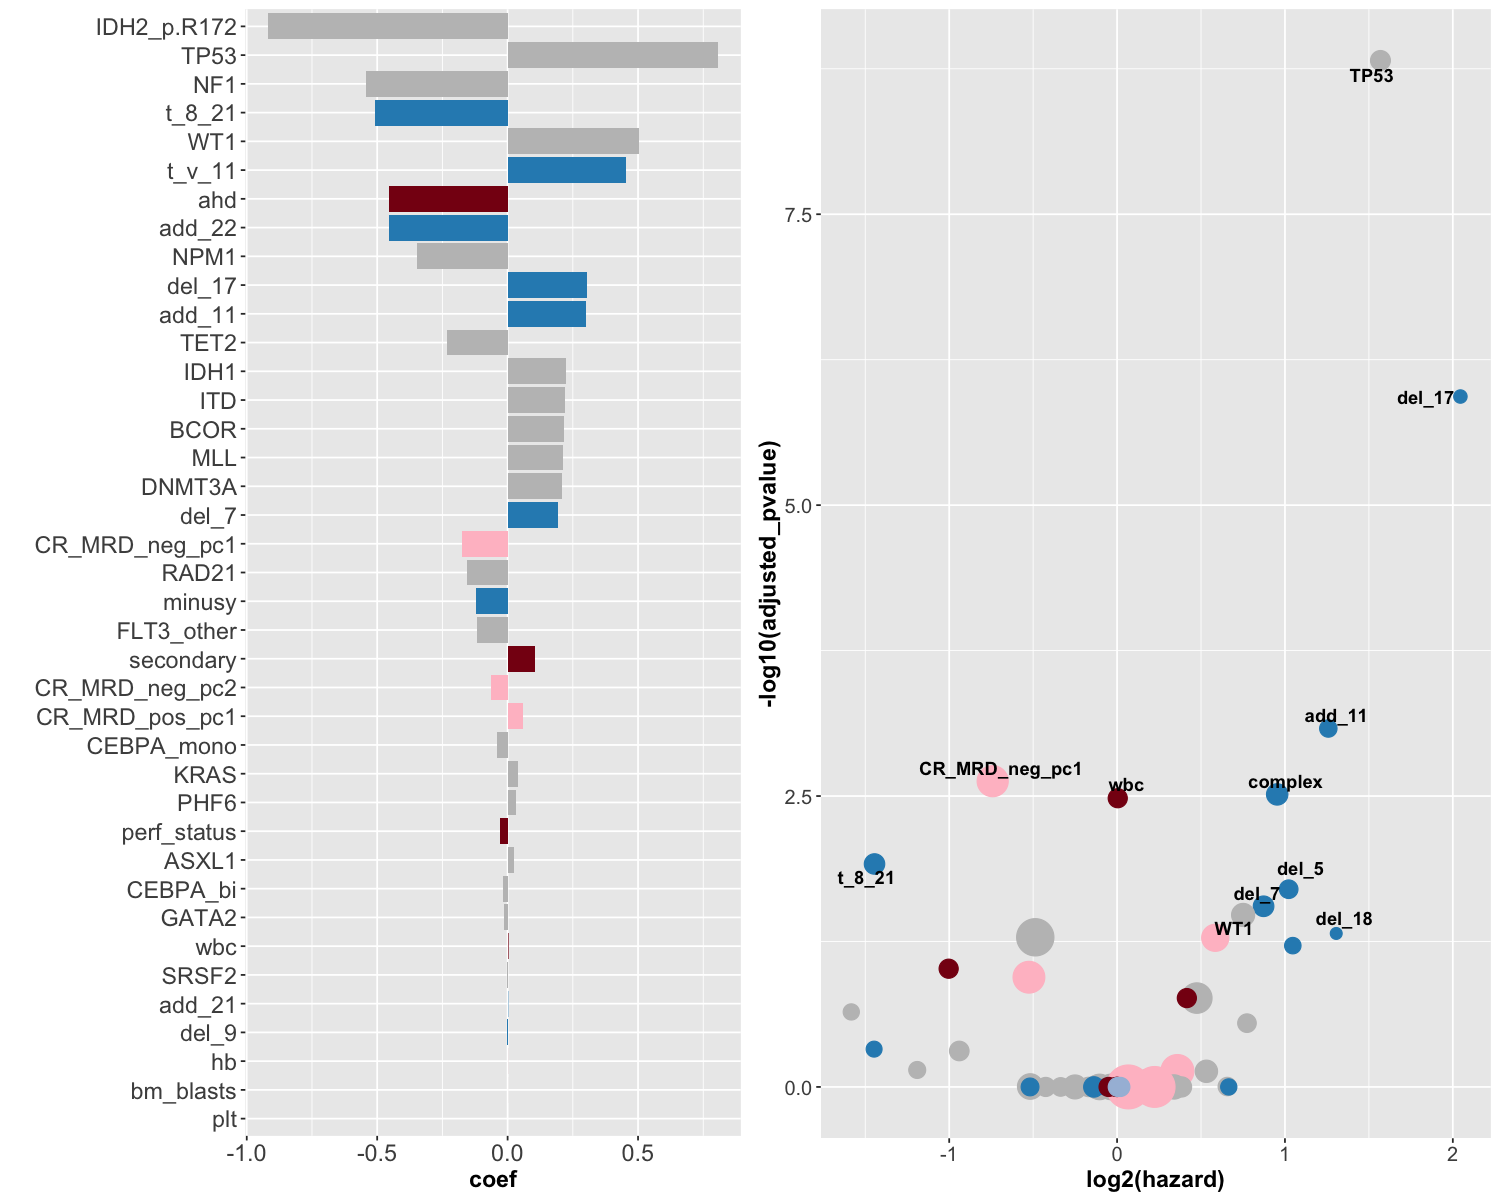

In [7]:
set_notebook_plot_size(12.5,10)
grid.arrange(t,s,nrow=1)

In [23]:
# png("rfs.png",width=7000,height=3550,res=350)
grid.arrange(t,s,nrow=1)
# dev.off()

pdf 
  2

# III.2) OS_CR

In [24]:
df <- data.frame(hazard = double(),pvalue = double(),Frequency = double() )
data <- df_merge_post_course

for (col in c(gen,cyto,mrd,clin,demo)){
    surv_object <- Surv(time = data$OS_CR, event = data$DEADStatus)
    fit <- coxph(as.formula(paste("Surv(OS_CR,DEADStatus) ~ ",
                       col)), data = data)

    df[col,1:3] <- c(summary(fit)$coef[2],summary(fit)$sctest[["pvalue"]],100*sum(data[,col])/dim(data)[1])                 
     }
df[,"adjusted_pvalue"] <- p.adjust(df$pvalue)
df[,"-log10(adjusted_pvalue)"] <- -log(p.adjust(df$pvalue),10)
df[,"log2(hazard)"] <- log(df$hazard,2)
df["names"] <- rownames(df)
df$Model <- ifelse(df$names %in% gen,"gen",
                  ifelse(df$names %in% cyto,"cyto",
                        ifelse(df$names %in% clin, "clin",
                              ifelse(df$names %in% demo, "demo",
                                    ifelse(df$names %in% eln, "eln",
                                           ifelse(df$names %in% mrd, "mrd","comp"))))))
df$Frequency <- ifelse(df$names %in% clin, 5,
                              ifelse(df$names %in% demo, 5, df$Frequency))

df <- df[order(df$adjusted_pvalue),]
s <- ggplot(df, aes(log2(hazard), -log10(adjusted_pvalue))) + #volcanoplot with log2Foldchange versus pvalue
    geom_point(aes(size=Frequency,col=Model)) + geom_text_repel(data=df[(df["adjusted_pvalue"]<0.05) | (df["log2(hazard)"]< -18),], aes(label=names,fontface=2))+scale_size_continuous(range = c(3,12)) + 
     scale_color_manual(values=colors_analysis,limits=names(colors_analysis))+  ## respect color in feature importance
    theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=12),axis.title=element_text(size=14,face="bold"))  + theme(legend.position="none")


## Multivariate Plot
   # we can not run lasso on a model without any events (variance 0)
data <- df_merge_post_course
df_multi <- NULL
i <- 1
for (i in c(1:100)){
    res1 <- cv.glmnet(data.matrix(data[,c(gen,cyto,mrd,clin,demo)]), Surv(data$OS_CR,data$DEADStatus), family="cox",alpha=1,nfolds=10)
    df_multi <- cbind(df_multi,as.matrix(coef(res1,s="lambda.min")))
    i <- i+1
    }

l <- data.frame(coef = rowSums(df_multi)/100)
l$names <- rownames(l)
l$Model <- ifelse(l$names %in% gen,"gen",
              ifelse(l$names %in% cyto,"cyto",
                    ifelse(l$names %in% clin, "clin",
                          ifelse(l$names %in% demo, "demo",
                                ifelse(l$names %in% eln, "eln",
                                       ifelse(l$names %in% mrd, "mrd","comp"))))))
l$abs_coef <- abs(l$coef)
t <- ggplot(l[l$coef!=0,],aes(x=reorder(names,abs_coef),y=coef,fill=Model))+geom_bar(stat="identity")+coord_flip()+
theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=14),axis.title=element_text(size=14,face="bold"))+
scale_fill_manual(values=colors_analysis,limits=names(colors_analysis)) + theme(legend.position="none")+xlab("")



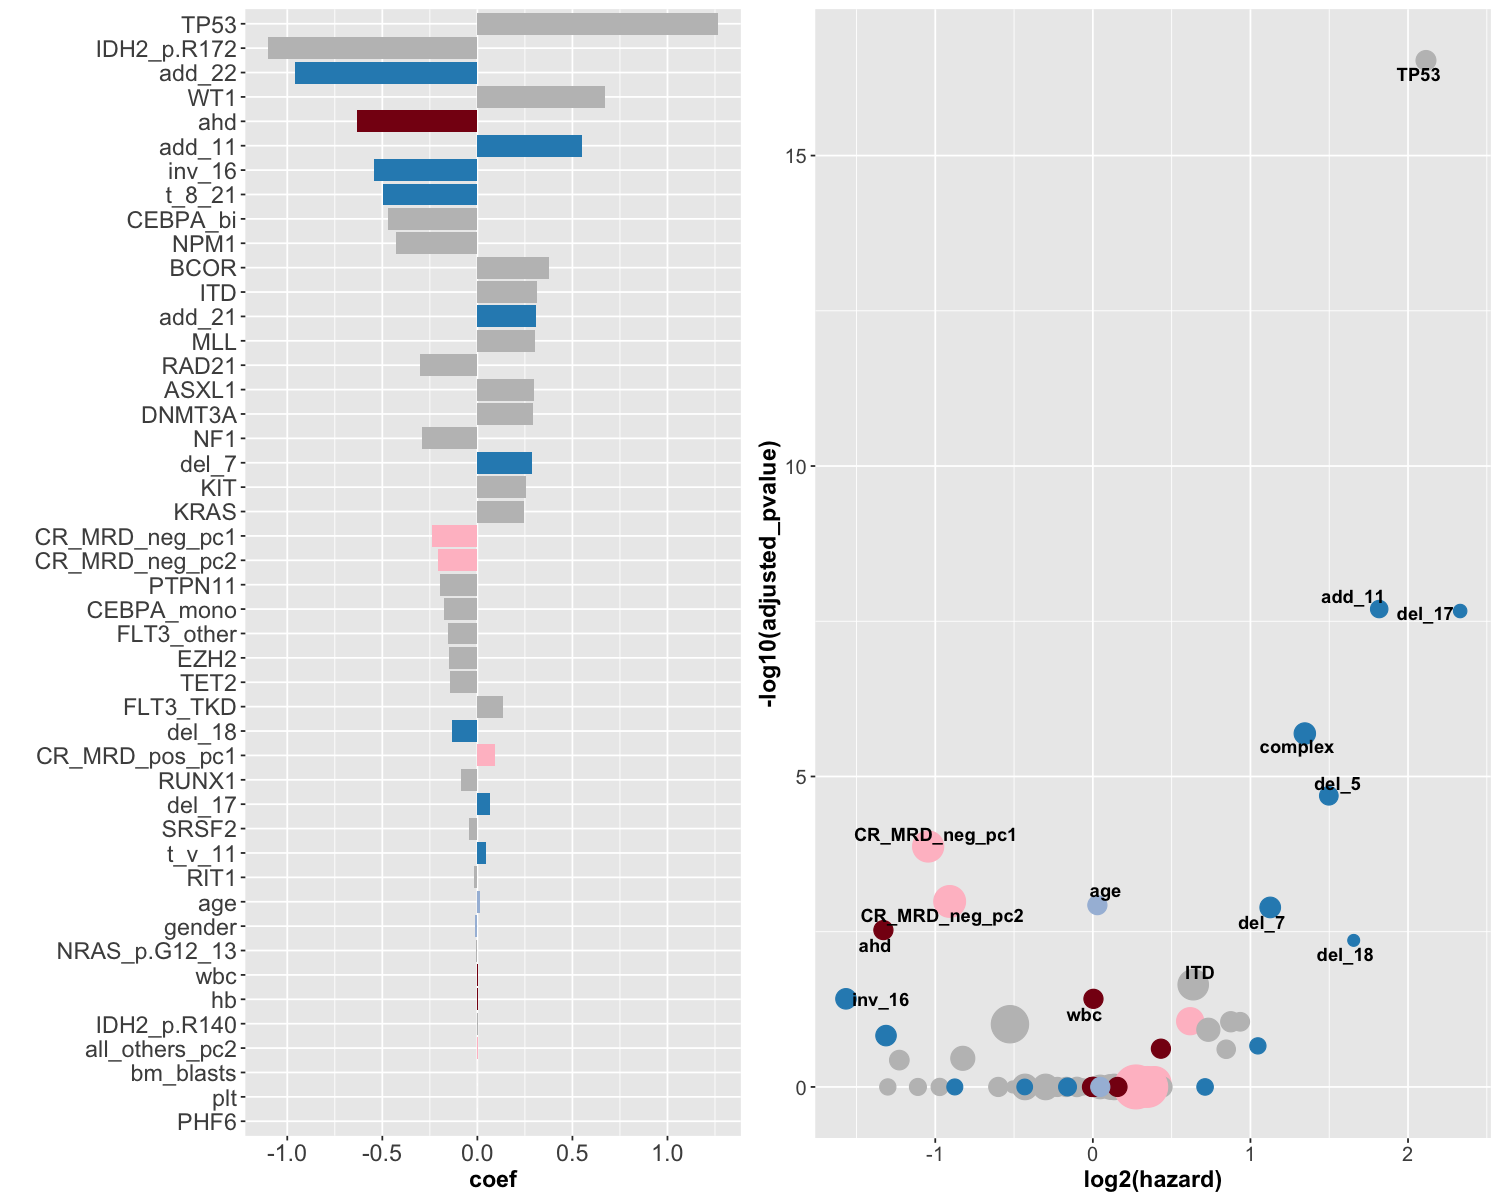

In [25]:
grid.arrange(t,s,nrow=1)

In [26]:
df

,hazard,pvalue,Frequency,adjusted_pvalue,-log10(adjusted_pvalue),log2(hazard),names,Model
TP53,4.3285552,4.664555e-19,5.652759,2.938670e-17,16.53184923,2.113885563,TP53,gen
add_11,3.5235869,3.242474e-10,3.768506,2.010334e-08,7.69673176,1.817044805,add_11,cyto
del_17,5.0310257,3.548132e-10,2.153432,2.164361e-08,7.66467035,2.330852545,del_17,cyto
complex,2.5405219,3.389097e-08,7.133244,2.033458e-06,5.69176478,1.345124927,complex,cyto
del_5,2.8233578,3.464323e-07,4.576043,2.043951e-05,4.68952956,1.497411990,del_5,cyto
CR_MRD_neg_pc1,0.4845822,2.312780e-06,23.014805,1.341413e-04,3.87243764,-1.045186803,CR_MRD_neg_pc1,mrd
CR_MRD_neg_pc2,0.5326601,1.806065e-05,24.495289,1.029457e-03,2.98739172,-0.908712989,CR_MRD_neg_pc2,mrd
age,1.0200524,2.105924e-05,5.000000,1.179318e-03,2.92836921,0.028643207,age,demo
del_7,2.1818414,2.337095e-05,6.325707,1.285402e-03,2.89096096,1.125546218,del_7,cyto
ahd,0.3979916,5.512494e-05,5.000000,2.976747e-03,2.52625810,-1.329190165,ahd,clin


In [26]:
df <- data.frame(hazard = double(),pvalue = double(),Frequency = double() )
data <- df_merge_post_course

for (col in c(gen,cyto,mrd,clin,demo)){
    surv_object <- Surv(time = data$OS_CR, event = data$DEADStatus)
    fit <- coxph(as.formula(paste("Surv(OS_CR,DEADStatus) ~ ",
                       col)), data = data)

    df[col,1:3] <- c(summary(fit)$coef[2],summary(fit)$sctest[["pvalue"]],100*sum(data[,col])/dim(data)[1])                 
     }
df[,"adjusted_pvalue"] <- p.adjust(df$pvalue)
df[,"-log10(adjusted_pvalue)"] <- -log(p.adjust(df$pvalue),10)
df[,"log2(hazard)"] <- log(df$hazard,2)
df["names"] <- rownames(df)
df$Model <- ifelse(df$names %in% gen,"gen",
                  ifelse(df$names %in% cyto,"cyto",
                        ifelse(df$names %in% clin, "clin",
                              ifelse(df$names %in% demo, "demo",
                                    ifelse(df$names %in% eln, "eln",
                                           ifelse(df$names %in% mrd, "mrd","comp"))))))
df$Frequency <- ifelse(df$names %in% clin, 5,
                              ifelse(df$names %in% demo, 5, df$Frequency))

df <- df[order(df$adjusted_pvalue),]
s <- ggplot(df, aes(log2(hazard), -log10(adjusted_pvalue))) + #volcanoplot with log2Foldchange versus pvalue
    geom_point(aes(size=Frequency,col=Model)) + geom_text_repel(data=df[(df["adjusted_pvalue"]<0.05) | (df["log2(hazard)"]< -18),], aes(label=names,fontface=2))+scale_size_continuous(range = c(3,12)) + 
     scale_color_manual(values=colors_analysis,limits=names(colors_analysis))+  ## respect color in feature importance
    theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=12),axis.title=element_text(size=14,face="bold"))  + theme(legend.position="none")


## Multivariate Plot
   # we can not run lasso on a model without any events (variance 0)
data <- df_merge
df_multi <- NULL
i <- 1
for (i in c(1:100)){
    res1 <- cv.glmnet(data.matrix(data[,c(gen,cyto,mrd,clin,demo)]), Surv(data$OS_CR,data$DEADStatus), family="cox",alpha=1,nfolds=10)
    df_multi <- cbind(df_multi,as.matrix(coef(res1,s="lambda.min")))
    i <- i+1
    }

l <- data.frame(coef = rowSums(df_multi)/100)
l$names <- rownames(l)
l$Model <- ifelse(l$names %in% gen,"gen",
              ifelse(l$names %in% cyto,"cyto",
                    ifelse(l$names %in% clin, "clin",
                          ifelse(l$names %in% demo, "demo",
                                ifelse(l$names %in% eln, "eln",
                                       ifelse(l$names %in% mrd, "mrd","comp"))))))
l$abs_coef <- abs(l$coef)
t <- ggplot(l[l$coef!=0,],aes(x=reorder(names,abs_coef),y=coef,fill=Model))+geom_bar(stat="identity")+coord_flip()+
theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=14),axis.title=element_text(size=14,face="bold"))+
scale_fill_manual(values=colors_analysis,limits=names(colors_analysis)) + theme(legend.position="none")+xlab("")



pdf 
  2

# III.3) OS

In [38]:
    ## Volcano Plot Univariate
    
df <- data.frame(hazard = double(),pvalue = double(),Frequency = double() )
data <- df_merge

for (col in c(gen,cyto,mrd,clin,demo)){
    surv_object <- Surv(time = data$os, event = data$os_status)
    fit <- coxph(as.formula(paste("Surv(os, os_status) ~ ",
                       col)), data = data)

    df[col,1:3] <- c(summary(fit)$coef[2],summary(fit)$sctest[["pvalue"]],100*sum(data[,col])/dim(data)[1])                 
     }
df[,"adjusted_pvalue"] <- p.adjust(df$pvalue)
df[,"-log10(adjusted_pvalue)"] <- -log(p.adjust(df$pvalue),10)
df[,"log2(hazard)"] <- log(df$hazard,2)
df["names"] <- rownames(df)
df$Model <- ifelse(df$names %in% gen,"gen",
                  ifelse(df$names %in% cyto,"cyto",
                        ifelse(df$names %in% clin, "clin",
                              ifelse(df$names %in% demo, "demo",
                                    ifelse(df$names %in% eln, "eln",
                                           ifelse(df$names %in% mrd, "mrd","comp"))))))
df$Frequency <- ifelse(df$names %in% clin, 5,
                              ifelse(df$names %in% demo, 5, df$Frequency))

df <- df[order(df$adjusted_pvalue),]
s <- ggplot(df, aes(log2(hazard), -log10(adjusted_pvalue))) + #volcanoplot with log2Foldchange versus pvalue
    geom_point(aes(size=Frequency,col=Model)) + geom_text_repel(data=df[(df["adjusted_pvalue"]<0.1) | (df["log2(hazard)"]< -18),], aes(label=names,fontface=2))+scale_size_continuous(range = c(3,12)) + 
     scale_color_manual(values=colors_analysis,limits=names(colors_analysis))+  ## respect color in feature importance
    theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=12),axis.title=element_text(size=14,face="bold"))  + theme(legend.position="none")


## Multivariate Plot
   # we can not run lasso on a model without any events (variance 0)
data <- df_merge
df_multi <- NULL
i <- 1
for (i in c(1:100)){
    res1 <- cv.glmnet(data.matrix(data[,c(gen,cyto,mrd,clin,demo)]), Surv(data$os,data$os_status), family="cox",alpha=1,nfolds=10)
    df_multi <- cbind(df_multi,as.matrix(coef(res1,s="lambda.min")))
    i <- i+1
    }

l <- data.frame(coef = rowSums(df_multi)/100)
l$names <- rownames(l)
l$Model <- ifelse(l$names %in% gen,"gen",
              ifelse(l$names %in% cyto,"cyto",
                    ifelse(l$names %in% clin, "clin",
                          ifelse(l$names %in% demo, "demo",
                                ifelse(l$names %in% eln, "eln",
                                       ifelse(l$names %in% mrd, "mrd","comp"))))))
l$abs_coef <- abs(l$coef)
t <- ggplot(l[l$coef!=0,],aes(x=reorder(names,abs_coef),y=coef,fill=Model))+geom_bar(stat="identity")+coord_flip()+
theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=14),axis.title=element_text(size=14,face="bold"))+
scale_fill_manual(values=colors_analysis,limits=names(colors_analysis)) + theme(legend.position="none")+xlab("")



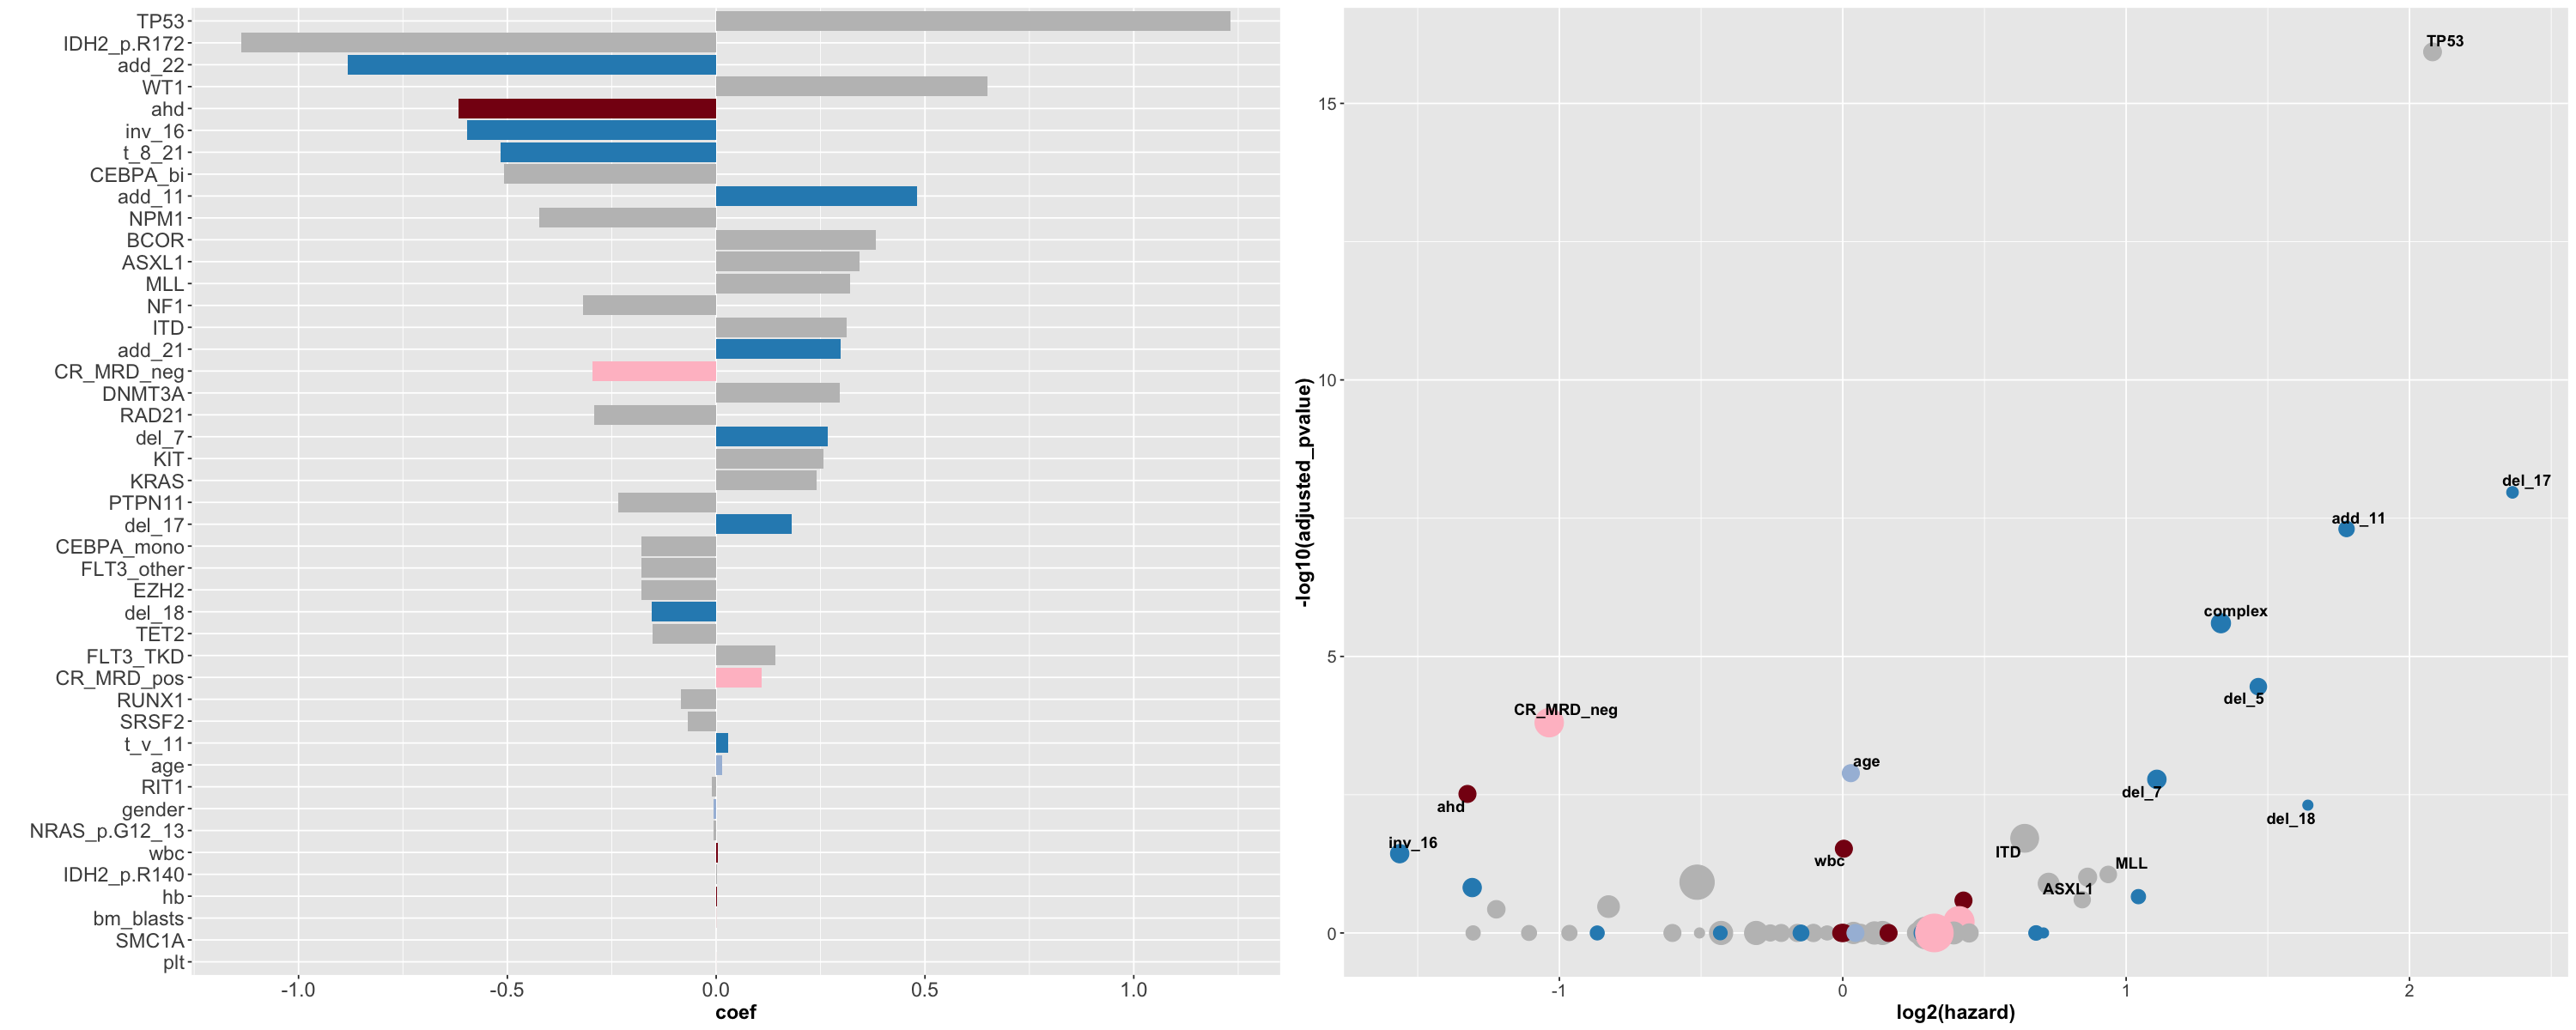

In [39]:
grid.arrange(t,s,nrow=1)

In [41]:
png("os.png",width=7000,height=3550,res=350)
grid.arrange(t,s,nrow=1)
dev.off()

pdf 
  2

In [ ]:
tmp <-read.table('../handovercompiled.Yanis.080919.csv',sep=",",header=T)
rownames(tmp) <- tmp$data_pd
cols_to_keep <- colnames(tmp)
master <- read.table('../../../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
rownames(master) <- master$data_pd
df <- read.table('../../../clustering/clustering_Final_1/df_final_full_component.tsv')
df_merge <- merge(df,master[,cols_to_keep],by=0)
rownames(df_merge) <- df_merge$Row.names
df_merge <- df_merge[-1]
df_merge$AMLID <- as.character(df_merge$AMLID)
df_merge$MRD1 <- as.character(df_merge$MRD1)
df_merge <- df_merge[grep("17-", df_merge$AMLID),]   ### keep only AML 17
df_merge$CR_MRD_neg <- ifelse(df_merge$MRD1=="CR,MRD-",1,0)
df_merge$CR_MRD_pos <- ifelse(df_merge$MRD1=="CR,MRD+",1,0)
df_merge$all_others <- ifelse(df_merge$MRD1!="CR,MRD+" & df_merge$MRD1!="CR,MRD-",1,0)
df_merge <- df_merge[!is.na(df_merge$OS_CR),]
df_merge <- df_merge[!is.na(df_merge$MRD1),]
df_merge <- df_merge[df_merge$os >0 & df_merge$OS_CR >0 & df_merge$RFSyears>0,]

In [111]:
read <- read.table("../handovercompiled.Yanis.080919.csv",sep=",",header = T)

In [119]:
tmp <-read.table('../handovercompiled.Yanis.080919.csv',sep=",",header=T)
rownames(tmp) <- tmp$data_pd
cols_to_keep <- colnames(tmp)
master <- read.table('../../../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
rownames(master) <- master$data_pd
df <- read.table('../../../clustering/clustering_Final_1/df_final_full_component.tsv')
df_merge <- merge(df,master[,cols_to_keep],by=0)
rownames(df_merge) <- df_merge$Row.names
df_merge <- df_merge[-1]
df_merge$AMLID <- as.character(df_merge$AMLID)
df_merge$MRD1 <- as.character(df_merge$MRD1)
df_merge <- df_merge[grep("17-", df_merge$AMLID),] 

In [143]:
master <- read.table('../../../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
master$AMLID <- as.character(master$AMLID)
master <- master[grep("16-", master$AMLID),] 
table(master$MRD1)


CR no MRD data        CR,MRD-        CR,MRD+           MRD-           MRD+ 
             0              0              0             19             24 
         no CR     No CR data    No MRD data      Not in CR             PR 
             0              0             48             74              0 
            RD 
             0 

In [144]:
tmp <-read.table('../handovercompiled.Yanis.080919.csv',sep=",",header=T)
rownames(tmp) <- tmp$data_pd
cols_to_keep <- colnames(tmp)
master <- read.table('../../../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
rownames(master) <- master$data_pd
df <- read.table('../../../clustering/clustering_Final_1/df_final_full_component.tsv')
df_merge <- merge(df,master[,cols_to_keep],by=0)
rownames(df_merge) <- df_merge$Row.names
df_merge <- df_merge[-1]
df_merge$AMLID <- as.character(df_merge$AMLID)
df_merge$MRD1 <- as.character(df_merge$MRD1)
df_merge <- df_merge[grep("16-", df_merge$AMLID),] 
table(df_merge$MRD1)


       MRD-        MRD+ No MRD data   Not in CR 
         17          22          40          53 

In [149]:
tmp <-read.table('../handovercompiled.Yanis.080919.csv',sep=",",header=T)
table(tmp$RFSStatus)


   0    1 
 530 1364 

In [150]:
head(tmp)

donor_id,data_pd,sample_pd.x,date_entry,trtcode,AMLID,dead60,MRDgp1,MRDgp2,CRby1,⋯,RelapseCIStatus,DaystoFirstCR,CODCause,OS_CR,CRdate,randDate_PB,CRDate_PB,relapseDate_PB,boneDate_PB,longCR_PB
16-1065,PD20150a,PD20150a,1/22/2007,160031,16-1065,0,1,0,No,⋯,2,99,OTHER CANCER,4.405202,5/1/2007,0,0,0,0,0
16-1079,PD15295c,PD15295c,2/22/2007,160004,NA,NA,NA,NA,NA,⋯,2,32,GVHD,2.173854,3/26/2007,0,0,0,0,0
16-1083,PD20149c,PD20149c,2/3/2007,160003,16-1083,0,0,0,No,⋯,1,122,RECURRENT LEUK,4.030116,7/2/2007,0,0,0,0,0
16-1095,PD15248c,PD15248c,3/22/2007,160037,16-1095,0,0,0,Yes,⋯,1,39,RECURRENT LEUK,1.158111,4/30/2007,0,0,0,0,0
16-1110,PD15260c,PD15260c,12/4/2007,160002,16-1110,0,0,0,Yes,⋯,1,39,RECURRENT LEUK,2.069815,5/21/2007,0,0,0,0,0
16-1113,PD20148c,PD20148c,4/17/2007,160073,16-1113,0,2,0,Yes,⋯,1,28,39,2.220397,5/15/2007,0,0,0,0,0


In [153]:
table(tmp$RelapseCIStatus)


  0   1   2 
530 712 652 